## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-spaceNet-wavelet-red' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/wavelet/approx1e5/red'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

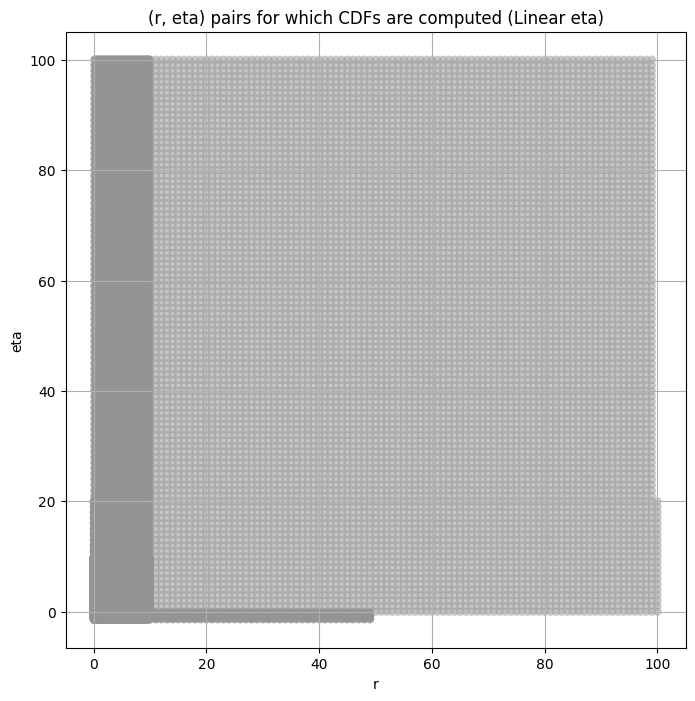

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:39<00:00, 2534.29it/s]


Layer 3


100%|██████████| 100000/100000 [00:43<00:00, 2306.97it/s]


Layer 4


100%|██████████| 100000/100000 [00:46<00:00, 2160.02it/s]


Layer 5


100%|██████████| 100000/100000 [00:45<00:00, 2215.87it/s]


Layer 6


100%|██████████| 100000/100000 [00:45<00:00, 2191.97it/s]


Layer 7


100%|██████████| 100000/100000 [00:44<00:00, 2225.97it/s]


Layer 8


100%|██████████| 100000/100000 [00:46<00:00, 2133.56it/s]


Layer 9


100%|██████████| 100000/100000 [00:47<00:00, 2125.40it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  
layer                             
2        6.006314        27208.0  
3       24.957214       108832.0  
4       16.255730       333298.0  
5       30.039886      1149538.0  
6       28.133839      4251250.0  
7       60.114044     17005000.0  
8       99.220190     68020000.0  
9      442.232270    272080000.0

## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


100%|██████████| 55966/55966 [00:58<00:00, 960.80it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 27208, Without approximation : 27208.0


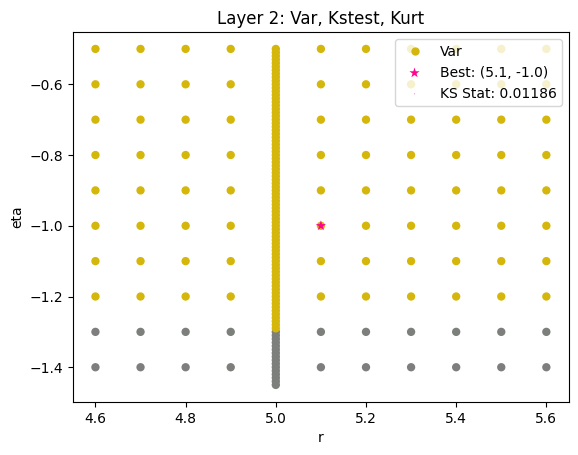

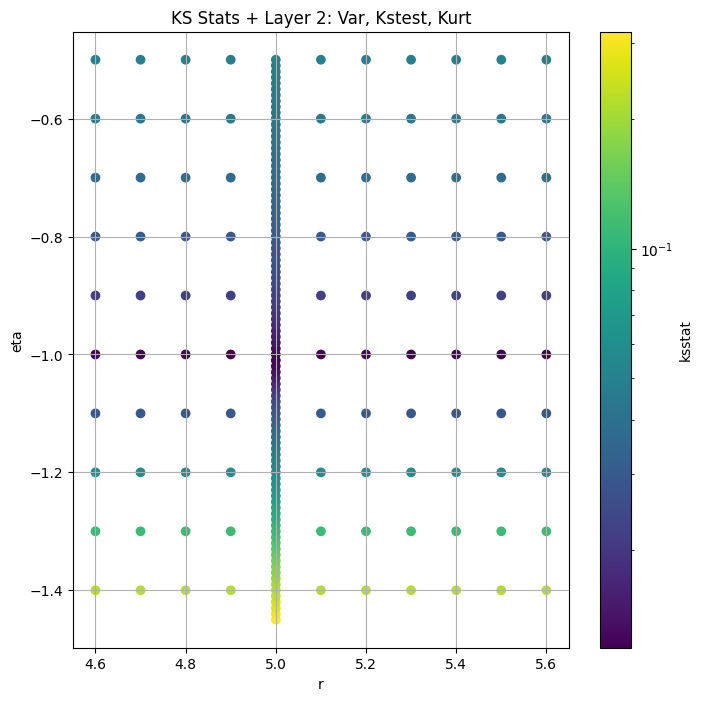

####
Layer  3


100%|██████████| 55966/55966 [03:17<00:00, 282.87it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 108832.0


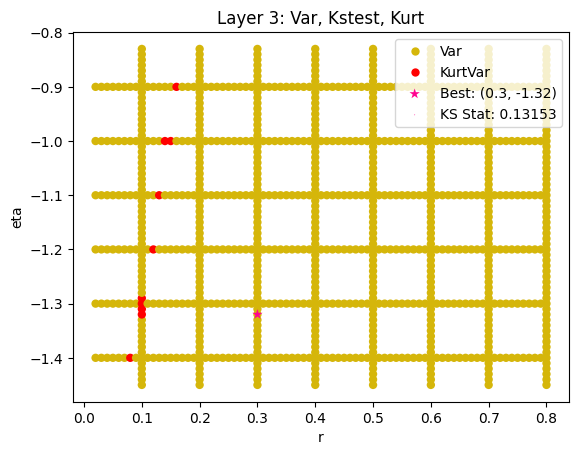

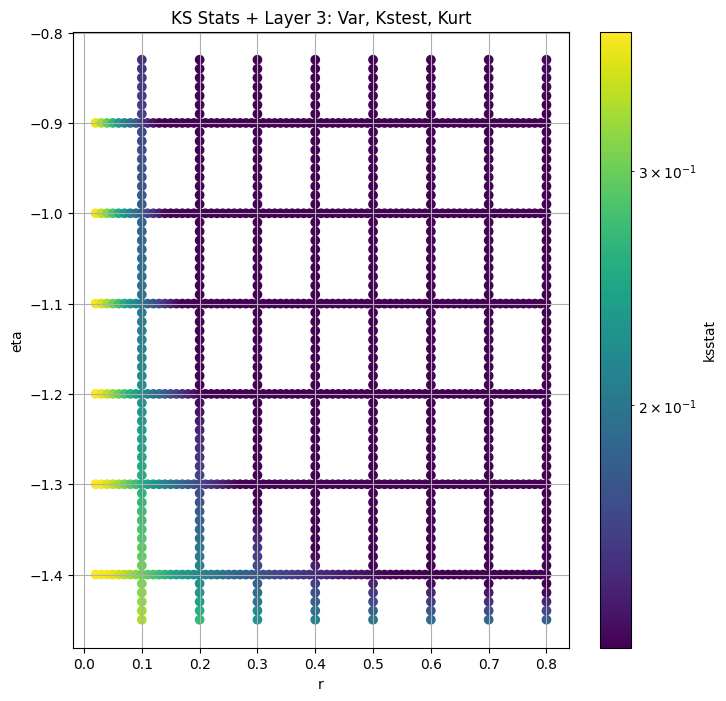

####
Layer  4


100%|██████████| 55966/55966 [03:11<00:00, 292.60it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 333298.0


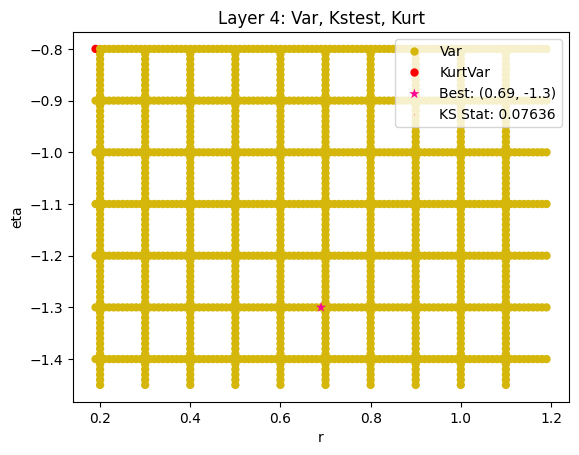

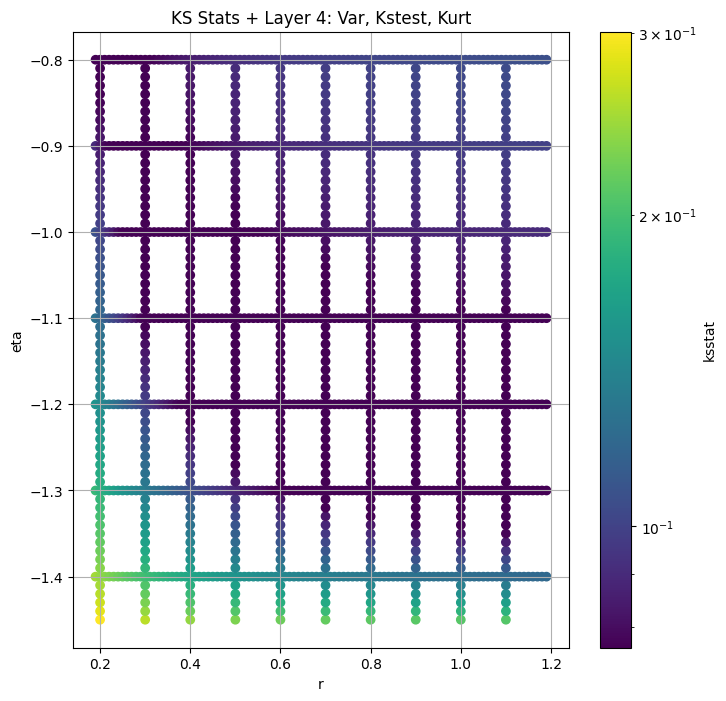

####
Layer  5


100%|██████████| 55966/55966 [03:05<00:00, 301.75it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1149538.0


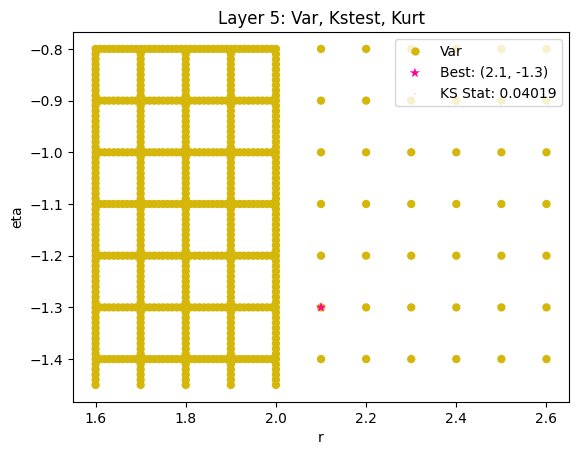

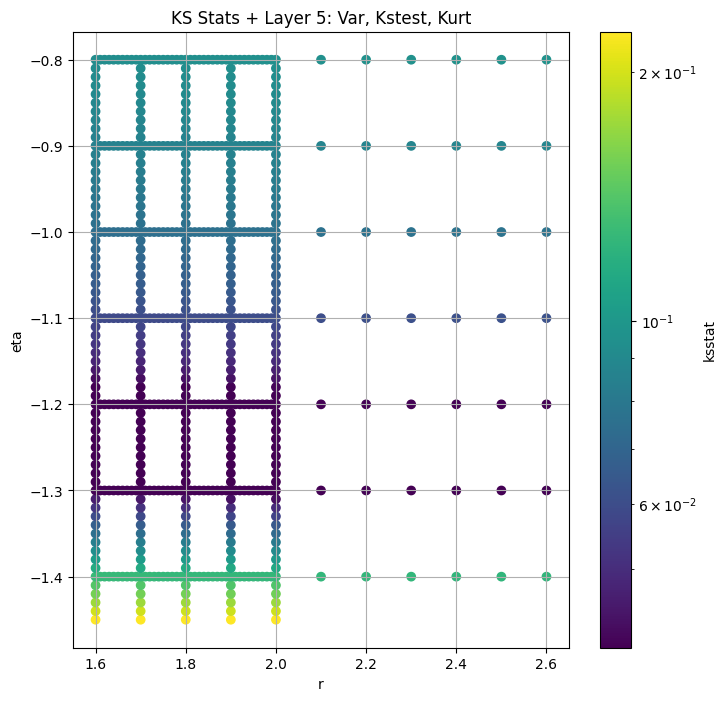

####
Layer  6


100%|██████████| 55966/55966 [03:06<00:00, 300.39it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 4251250.0


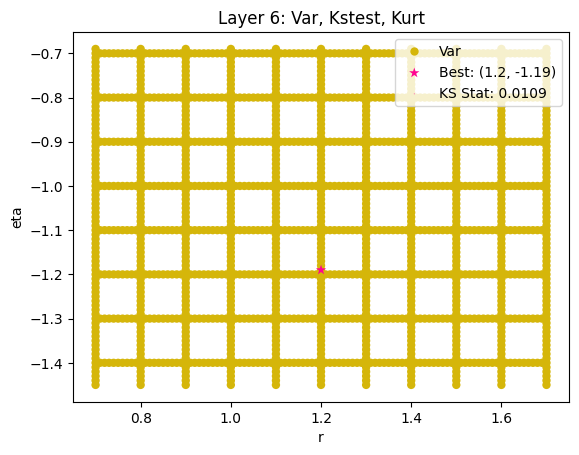

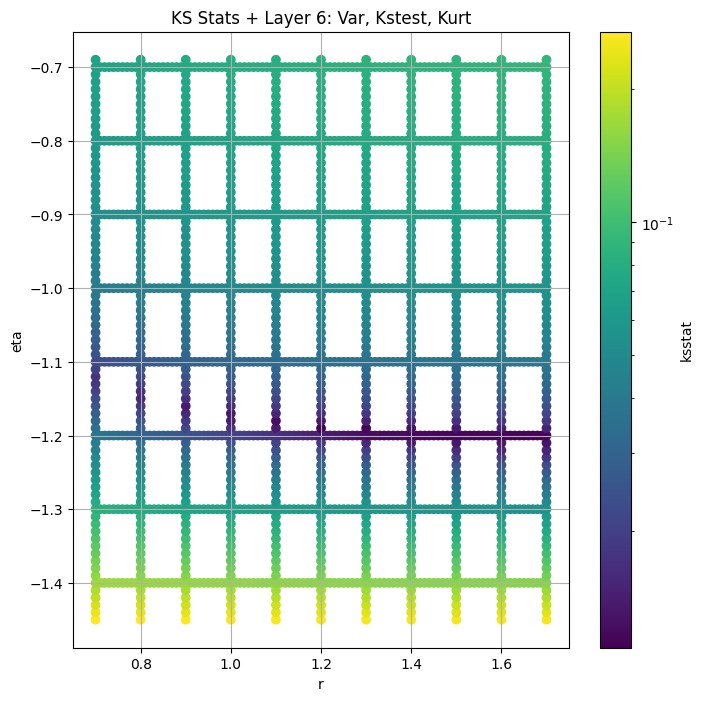

####
Layer  7


100%|██████████| 55966/55966 [03:07<00:00, 298.61it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 17005000.0


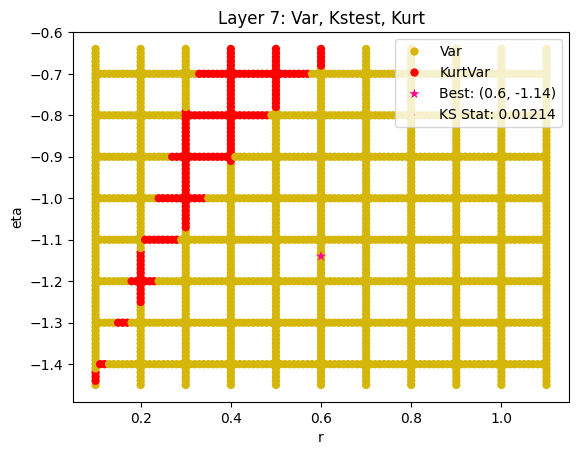

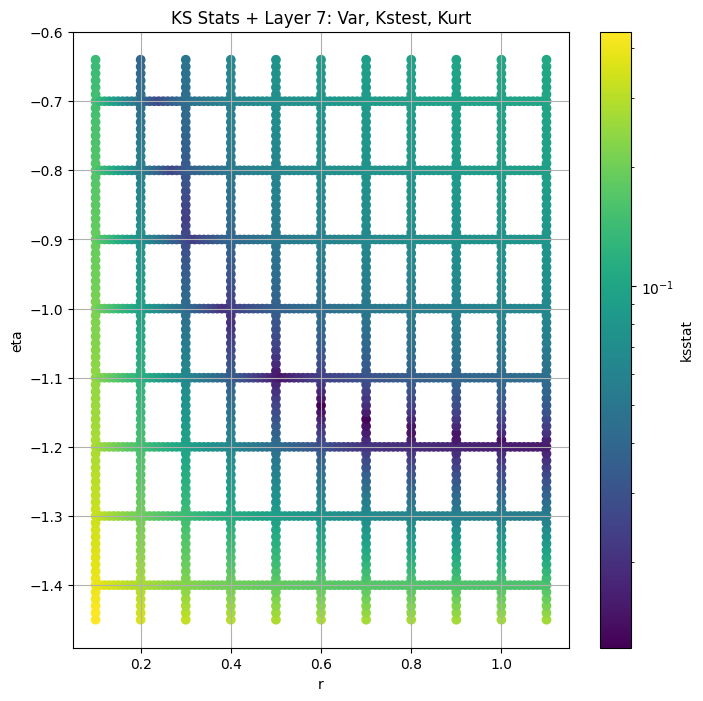

####
Layer  8


100%|██████████| 55966/55966 [03:09<00:00, 295.62it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 68020000.0


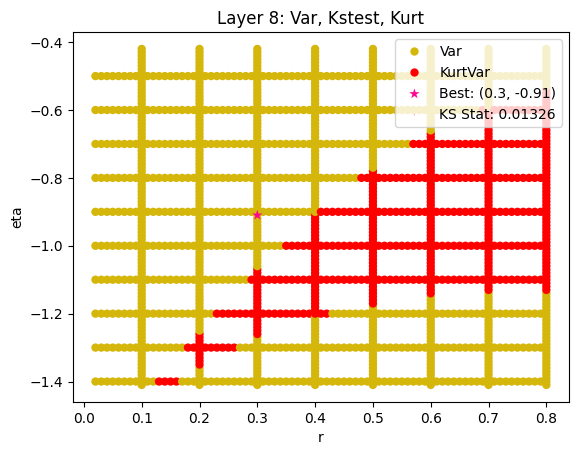

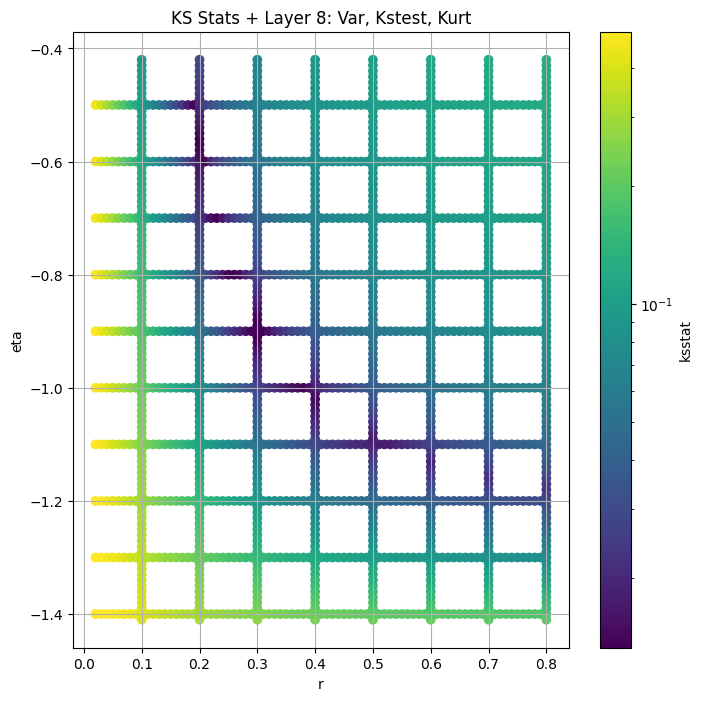

####
Layer  9


100%|██████████| 55966/55966 [03:12<00:00, 290.88it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 272080000.0


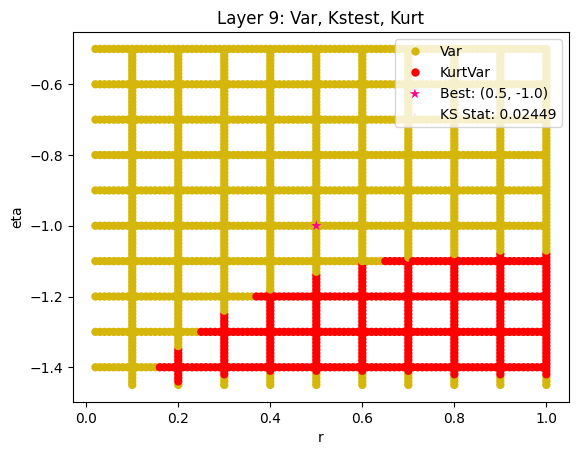

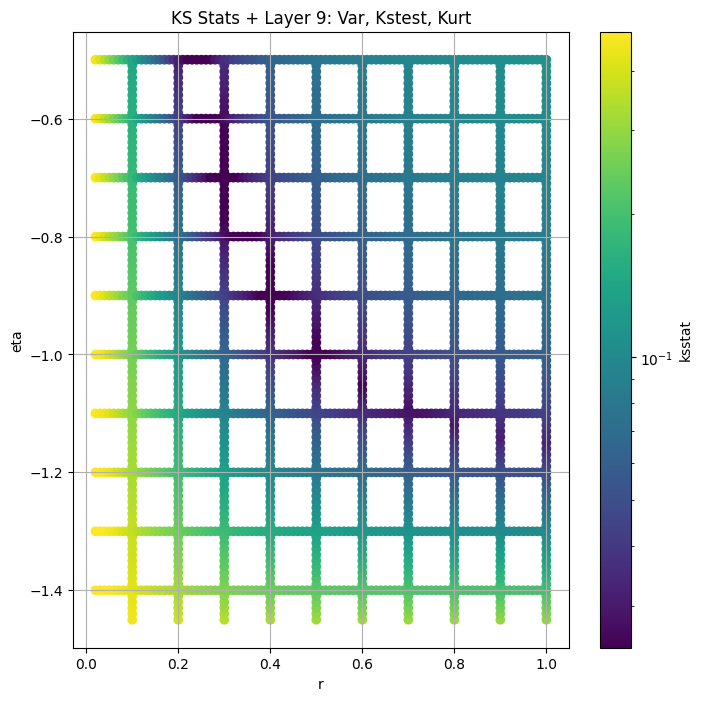

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        6.006314        27208.0       5.10        -1.00   54579.342195   
3       24.957214       108832.0       0.30        -1.32    1220.308144   
4       16.255730       333298.0       0.69        -1.30    4647.744608   
5       30.039886      1149538.0       2.10        -1.30    2401.725295   
6       28.133839      4251250.0       1.20        -1.19     332.177031   
7       60.114044     17005000.0       0.60        -1.14      27.160989   
8       99.220190     68020000.0       0.30        -0.91       0.117548   
9      442.232270    272080000.0       0.50        -1.00       0.425054   

       kstest_stat_initial  kstest_stat_cutoff_0.05  
layer                                                
2                 0.011858                 0.008227  
3                 0.131530                 0.004115  
4                 0.076360                 0.002352  
5                 0.040193                 0.001267  
6                 0.010903                 0.000659  
7                 0.012144                 0.000329  
8                 0.013255                 0.000165  
9                 0.024494                 0.000082

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 1025.85it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 294.11it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 298.21it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 288.25it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 295.74it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 237.01it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 269.96it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 284.16it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        6.006314        27208.0       5.10        -1.00   54579.342195   
3       24.957214       108832.0       0.30        -1.32    1220.308144   
4       16.255730       333298.0       0.69        -1.30    4647.744608   
5       30.039886      1149538.0       2.10        -1.30    2401.725295   
6       28.133839      4251250.0       1.20        -1.19     332.177031   
7       60.114044     17005000.0       0.60        -1.14      27.160989   
8       99.220190     68020000.0       0.30        -0.91       0.117548   
9      442.232270    272080000.0       0.50        -1.00       0.425054   

       kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
layer                                                              
2                 0.011858                 0.008227         6.00   
3                 0.131530                 0.004115         6.00   
4                 0.076360                 0.002352         5.90   
5                 0.040193                 0.001267         5.90   
6                 0.010903                 0.000659         5.80   
7                 0.012144                 0.000329         5.80   
8                 0.013255                 0.000165         5.80   
9                 0.024494                 0.000082         0.03   

       best_scale_eta0  kstest_stat_eta0  
layer                                     
2         1.448685e+00          0.160887  
3         1.448685e+00          0.277855  
4         1.447723e+00          0.340982  
5         1.447723e+00          0.395259  
6         1.446685e+00          0.437153  
7         1.446685e+00          0.463057  
8         1.446685e+00          0.478601  
9         2.497132e-61          0.480210

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(5.02, -1.03), 50 of 420
(5.04, -0.95), 100 of 420
(5.07, -1.08), 150 of 420
(5.09, -1.0), 200 of 420
(5.11, -0.92), 250 of 420
(5.14, -1.05), 300 of 420
(5.16, -0.97), 350 of 420
(5.19, -1.1), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 1033.06it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 2 best parameters: ((5.12, -1.0), 0.011857094609537933)


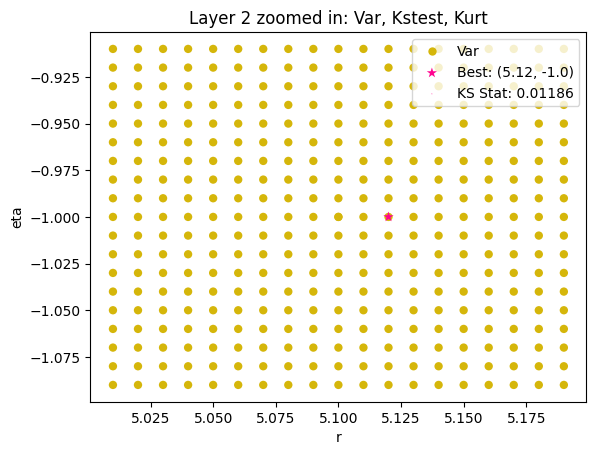

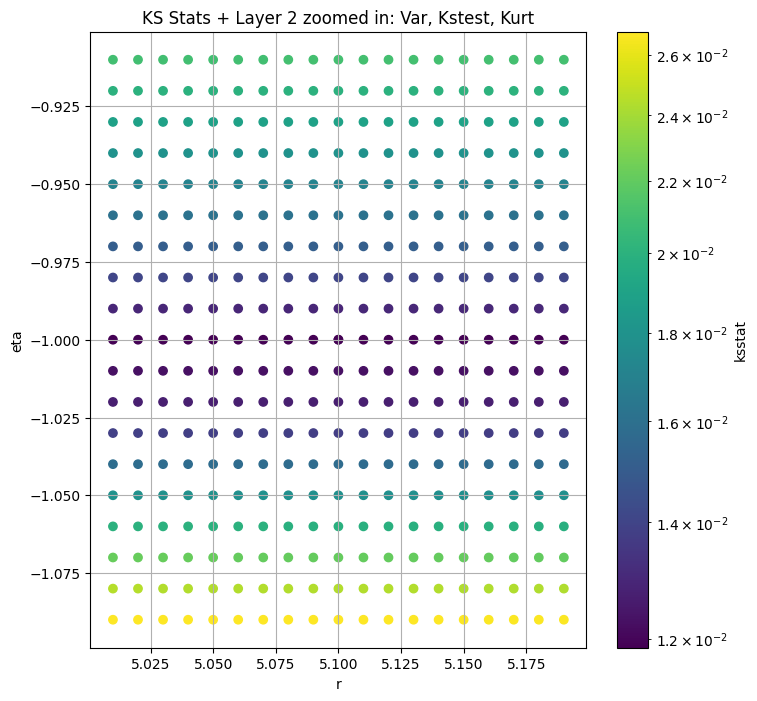

Layer 3
(0.22, -1.323), 50 of 441
(0.24, -1.315), 100 of 441
(0.27, -1.328), 150 of 441
(0.29, -1.32), 200 of 441
(0.31, -1.312), 250 of 441
(0.34, -1.325), 300 of 441
(0.36, -1.317), 350 of 441
(0.39, -1.33), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 299.51it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((0.29, -1.314), 0.13152999999999987)


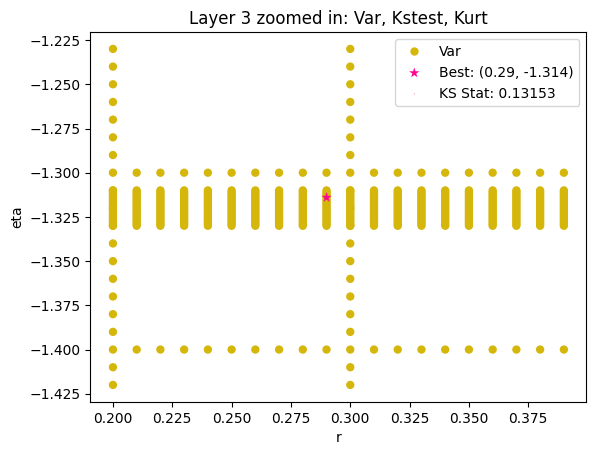

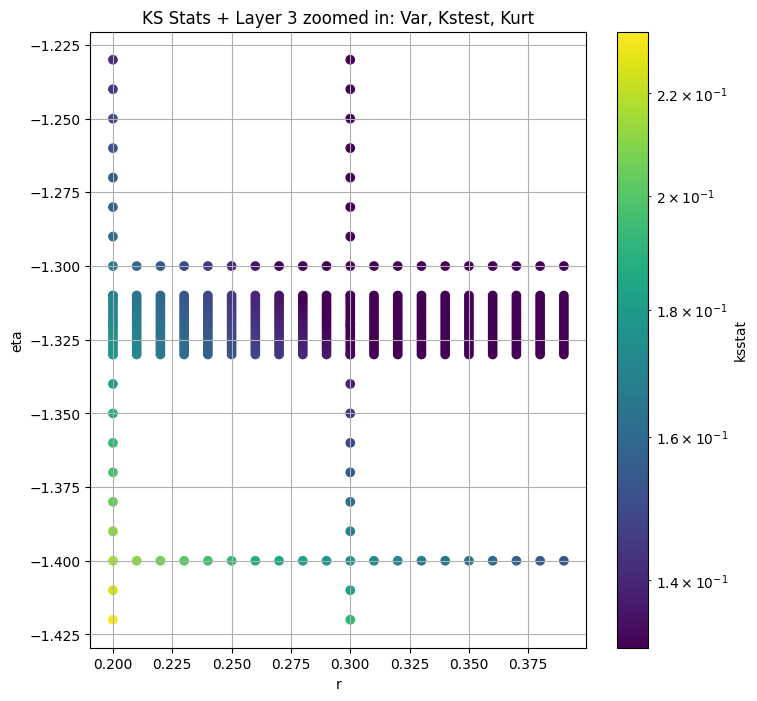

Layer 4
(0.682, -1.33), 50 of 441
(0.684, -1.25), 100 of 441
(0.687, -1.38), 150 of 441
(0.689, -1.3), 200 of 441
(0.691, -1.22), 250 of 441
(0.694, -1.35), 300 of 441
(0.696, -1.27), 350 of 441
(0.699, -1.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 301.14it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.682, -1.28), 0.07635999999999987)


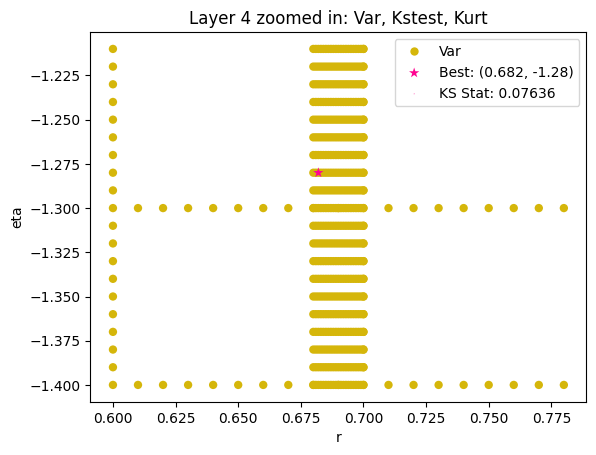

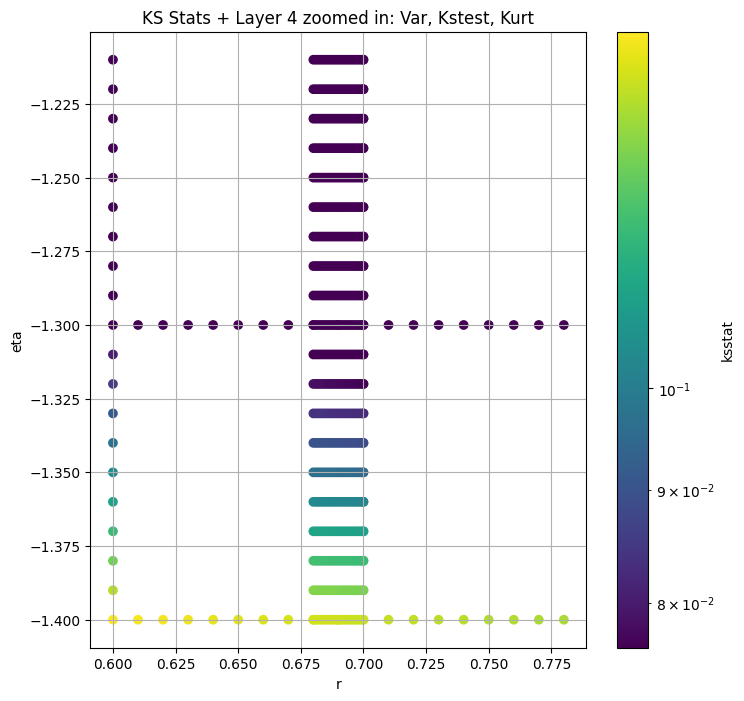

Layer 5
(2.02, -1.33), 50 of 441
(2.04, -1.25), 100 of 441
(2.07, -1.38), 150 of 441
(2.09, -1.3), 200 of 441
(2.11, -1.22), 250 of 441
(2.14, -1.35), 300 of 441
(2.16, -1.27), 350 of 441
(2.19, -1.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 305.84it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((2.0, -1.3), 0.04019323236788158)


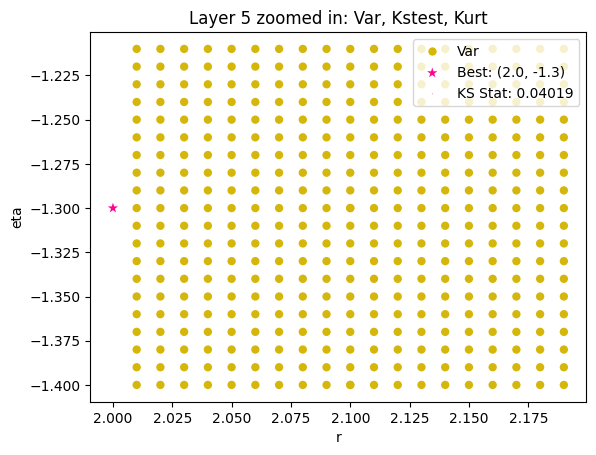

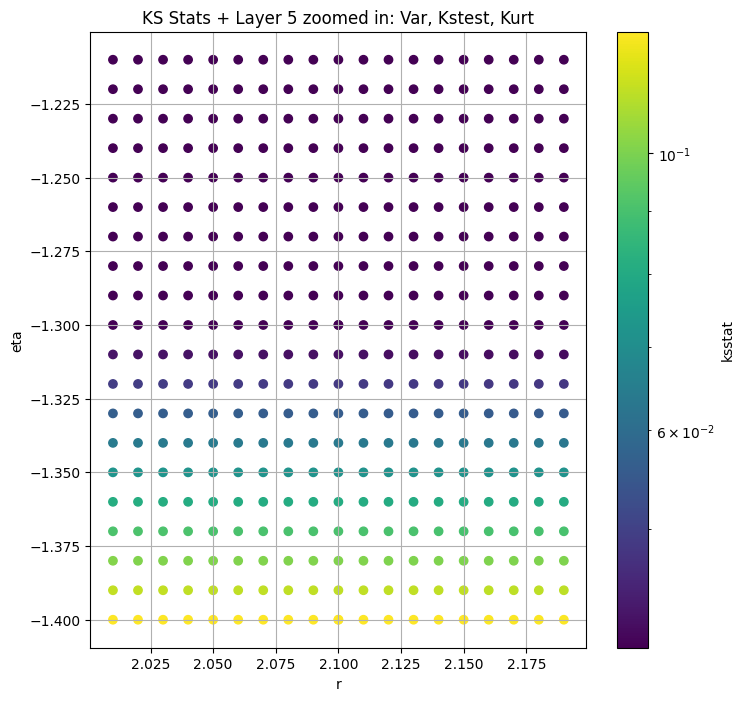

Layer 6
(1.12, -1.193), 50 of 441
(1.14, -1.185), 100 of 441
(1.17, -1.198), 150 of 441
(1.19, -1.19), 200 of 441
(1.21, -1.182), 250 of 441
(1.24, -1.195), 300 of 441
(1.26, -1.187), 350 of 441
(1.29, -1.2), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 309.49it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 6 best parameters: ((1.23, -1.191), 0.010495071732520567)


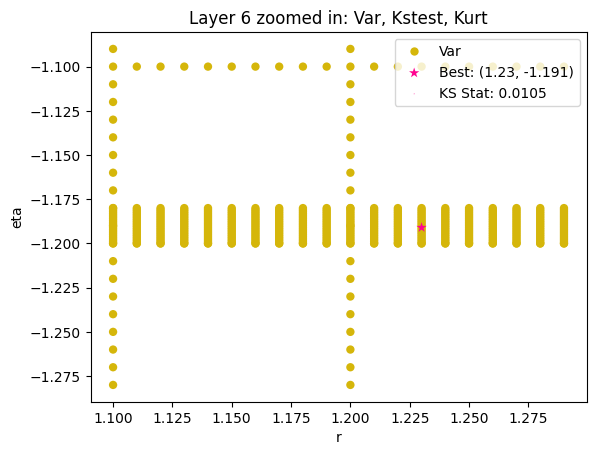

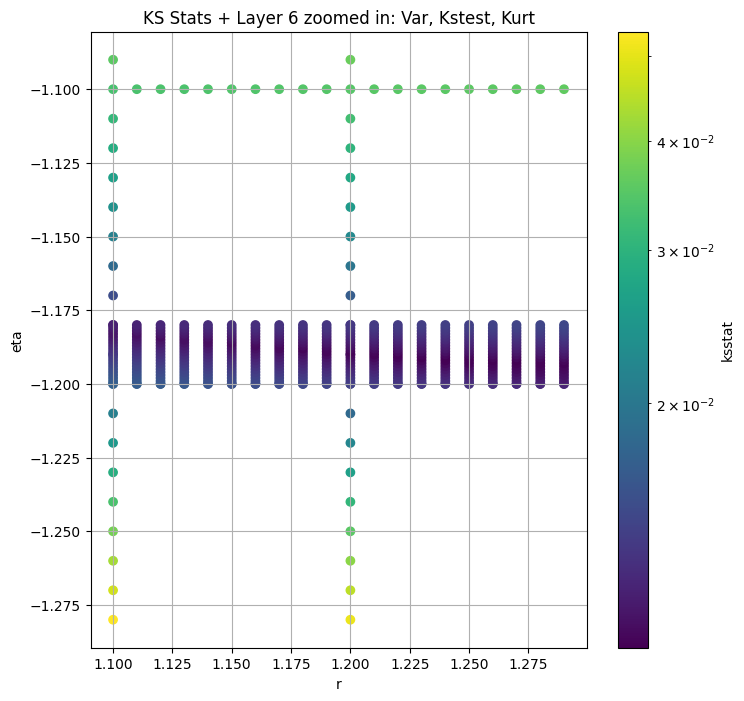

Layer 7
(0.52, -1.143), 50 of 420
(0.54, -1.135), 100 of 420
(0.57, -1.148), 150 of 420
(0.59, -1.14), 200 of 420
(0.61, -1.132), 250 of 420
(0.64, -1.145), 300 of 420
(0.66, -1.137), 350 of 420
(0.69, -1.15), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 307.89it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 7 best parameters: ((0.62, -1.146), 0.011885159290424774)


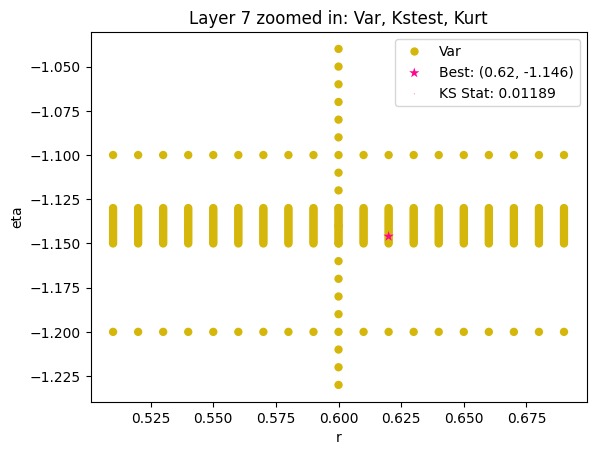

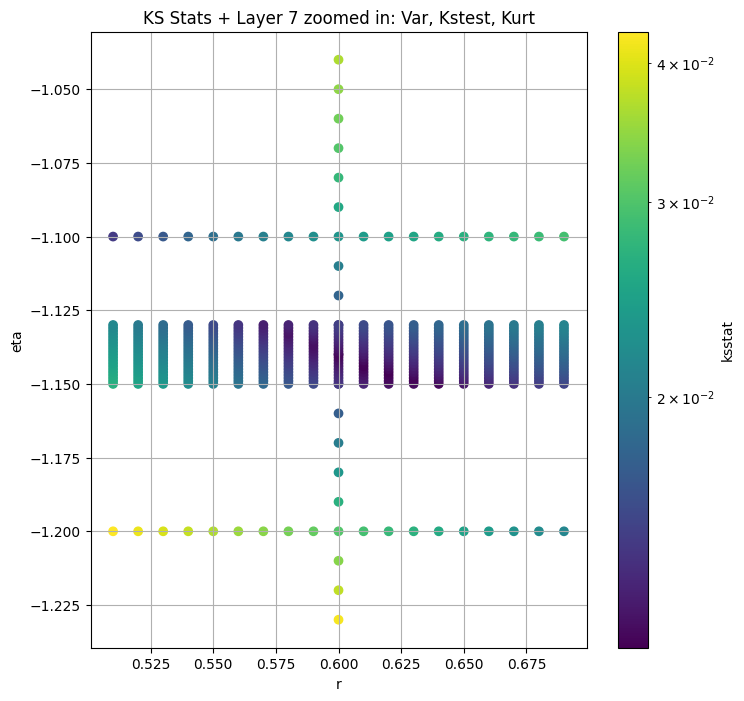

Layer 8
(0.22, -0.913), 50 of 441
(0.24, -0.905), 100 of 441
(0.27, -0.918), 150 of 441
(0.29, -0.91), 200 of 441
(0.31, -0.902), 250 of 441
(0.34, -0.915), 300 of 441
(0.36, -0.907), 350 of 441
(0.39, -0.92), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 307.79it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 8 best parameters: ((0.3, -0.912), 0.013254939866683468)


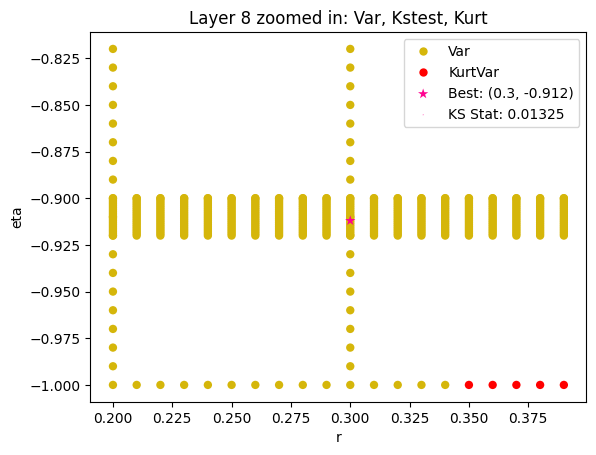

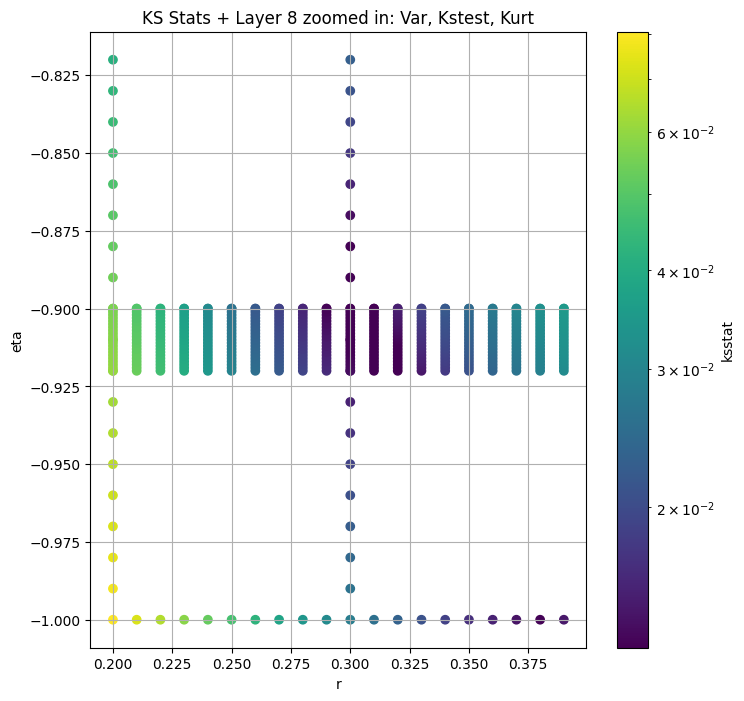

Layer 9
(0.492, -1.003), 50 of 441
(0.494, -0.995), 100 of 441
(0.497, -1.008), 150 of 441
(0.499, -1.0), 200 of 441
(0.501, -0.992), 250 of 441
(0.504, -1.005), 300 of 441
(0.506, -0.997), 350 of 441
(0.509, -1.01), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 307.51it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 9 best parameters: ((0.509, -1.009), 0.02449271894501337)


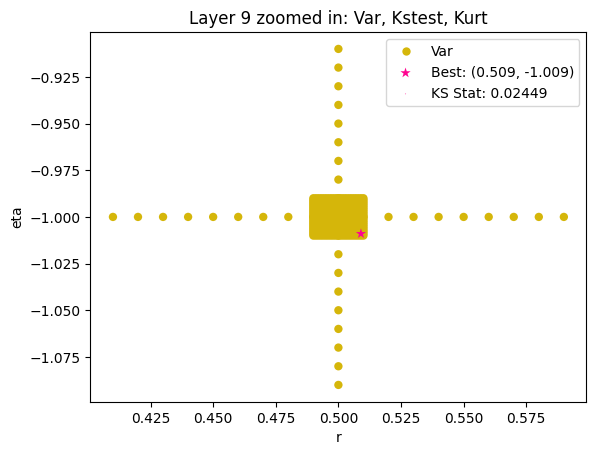

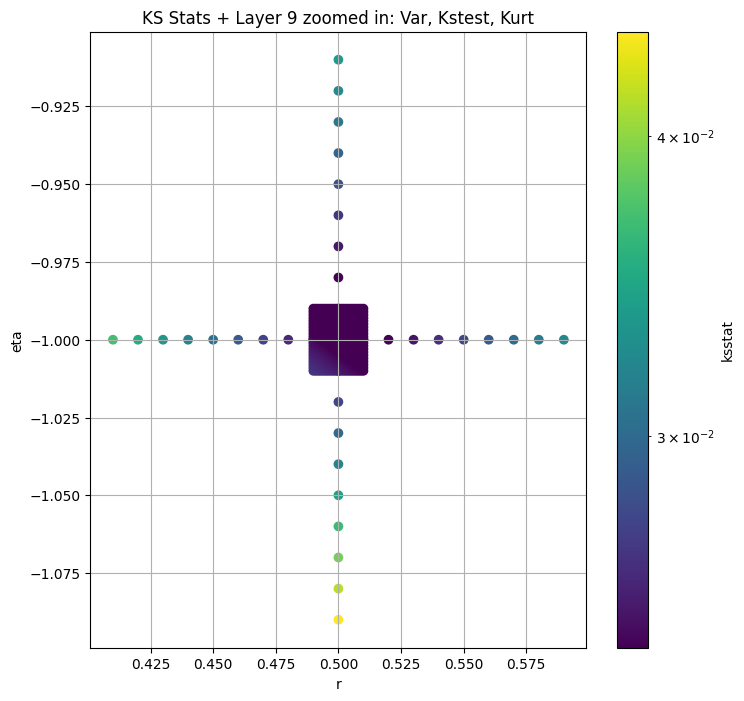

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.006314        27208.0       5.10        -1.00   54579.342195  ...   
3       24.957214       108832.0       0.30        -1.32    1220.308144  ...   
4       16.255730       333298.0       0.69        -1.30    4647.744608  ...   
5       30.039886      1149538.0       2.10        -1.30    2401.725295  ...   
6       28.133839      4251250.0       1.20        -1.19     332.177031  ...   
7       60.114044     17005000.0       0.60        -1.14      27.160989  ...   
8       99.220190     68020000.0       0.30        -0.91       0.117548  ...   
9      442.232270    272080000.0       0.50        -1.00       0.425054  ...   

       best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
layer                                                                      
2         1.448685e+00          0.160887   5.120    -1.000  54577.194033   
3         1.448685e+00          0.277855   0.290    -1.314    943.177695   
4         1.447723e+00          0.340982   0.682    -1.280   4101.158400   
5         1.447723e+00          0.395259   2.000    -1.300   2389.071933   
6         1.446685e+00          0.437153   1.230    -1.191    337.869637   
7         1.446685e+00          0.463057   0.620    -1.146     29.794742   
8         1.446685e+00          0.478601   0.300    -0.912      0.118469   
9         2.497132e-61          0.480210   0.509    -1.009      0.463100   

       kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
layer                                                                        
2              0.011857    5.120     -1.000           0.011857        13604  
3              0.131530    0.290     -1.314           0.131530          106  
4              0.076360    0.682     -1.280           0.076360          325  
5              0.040193    2.000     -1.300           0.040193         1122  
6              0.010495    1.230     -1.191           0.010495        16606  
7              0.011885    0.620     -1.146           0.011885        12454  
8              0.013255    0.300     -0.912           0.013255        10507  
9              0.024493    0.509     -1.009           0.024493         3112  

[8 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

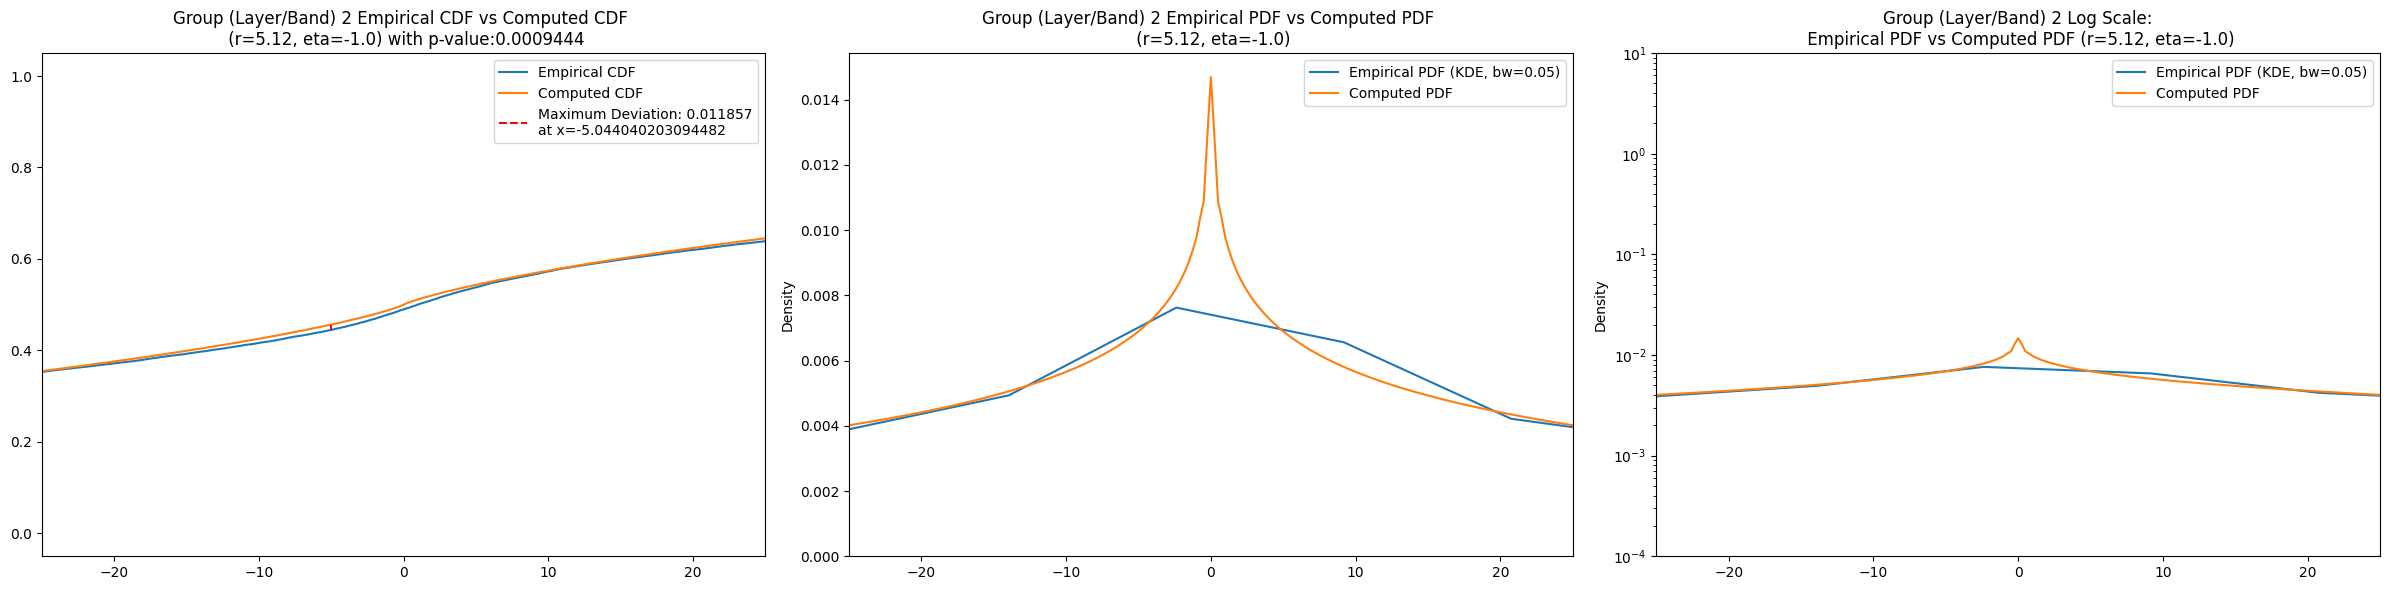

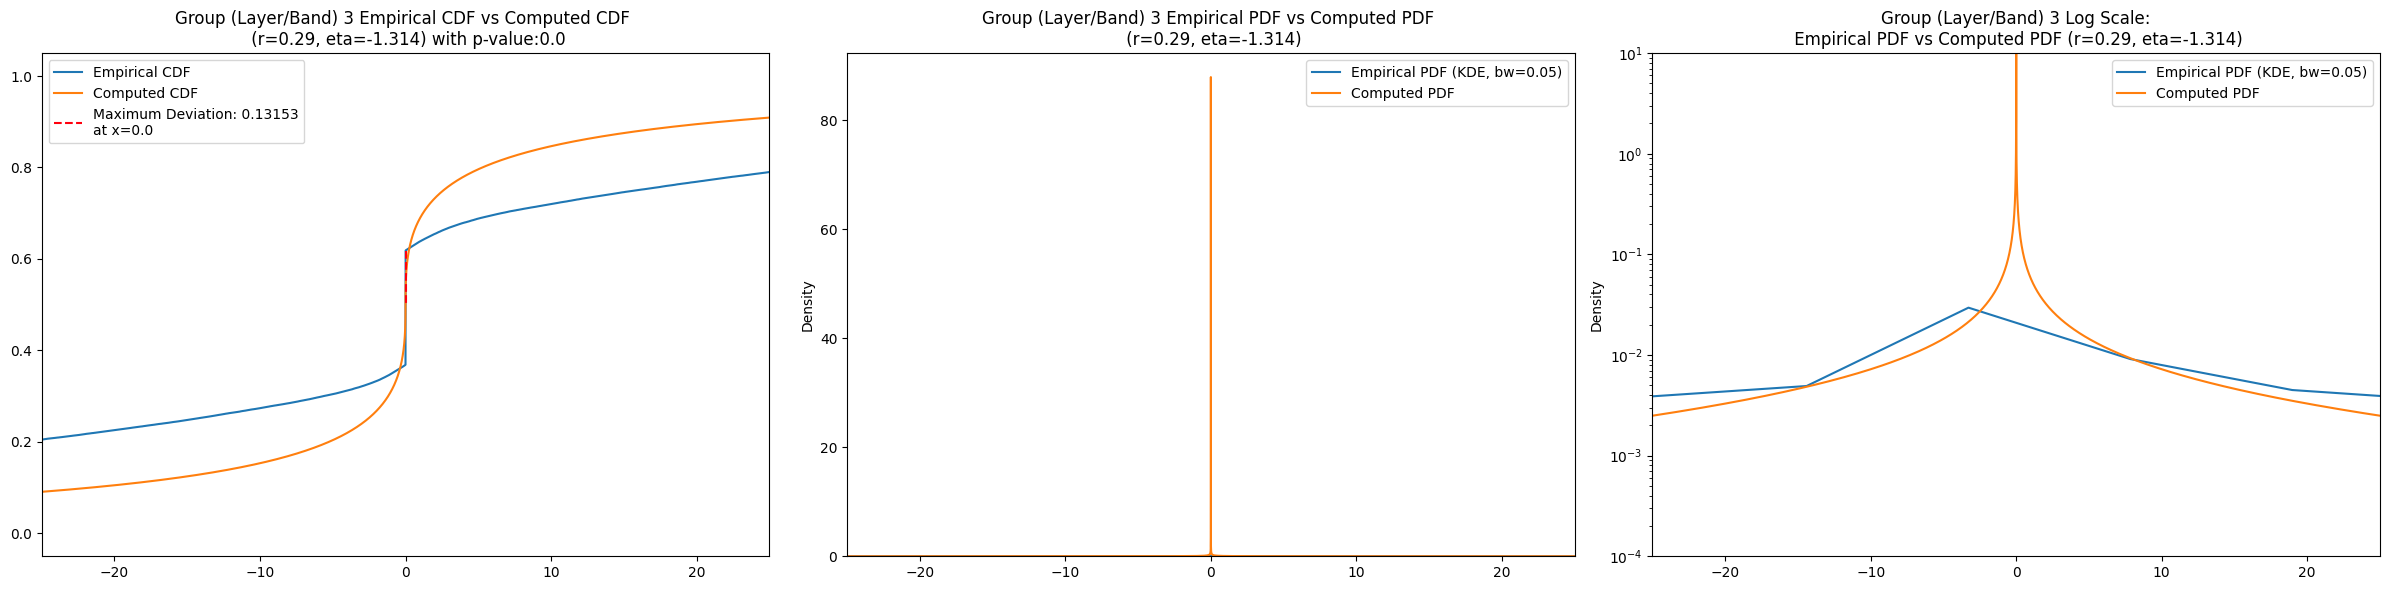

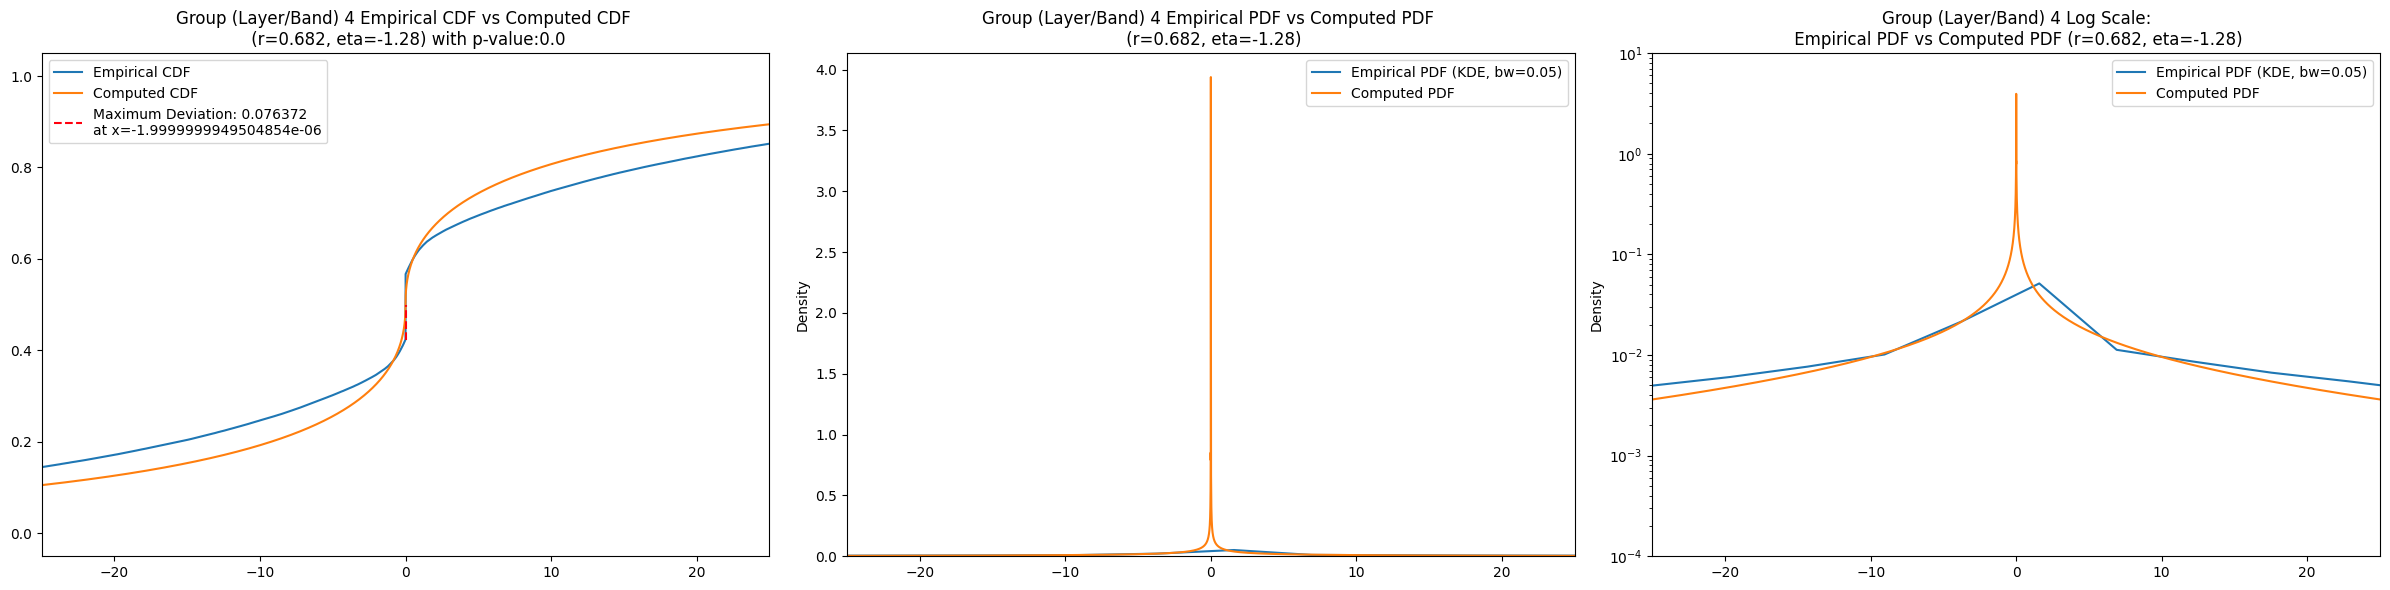

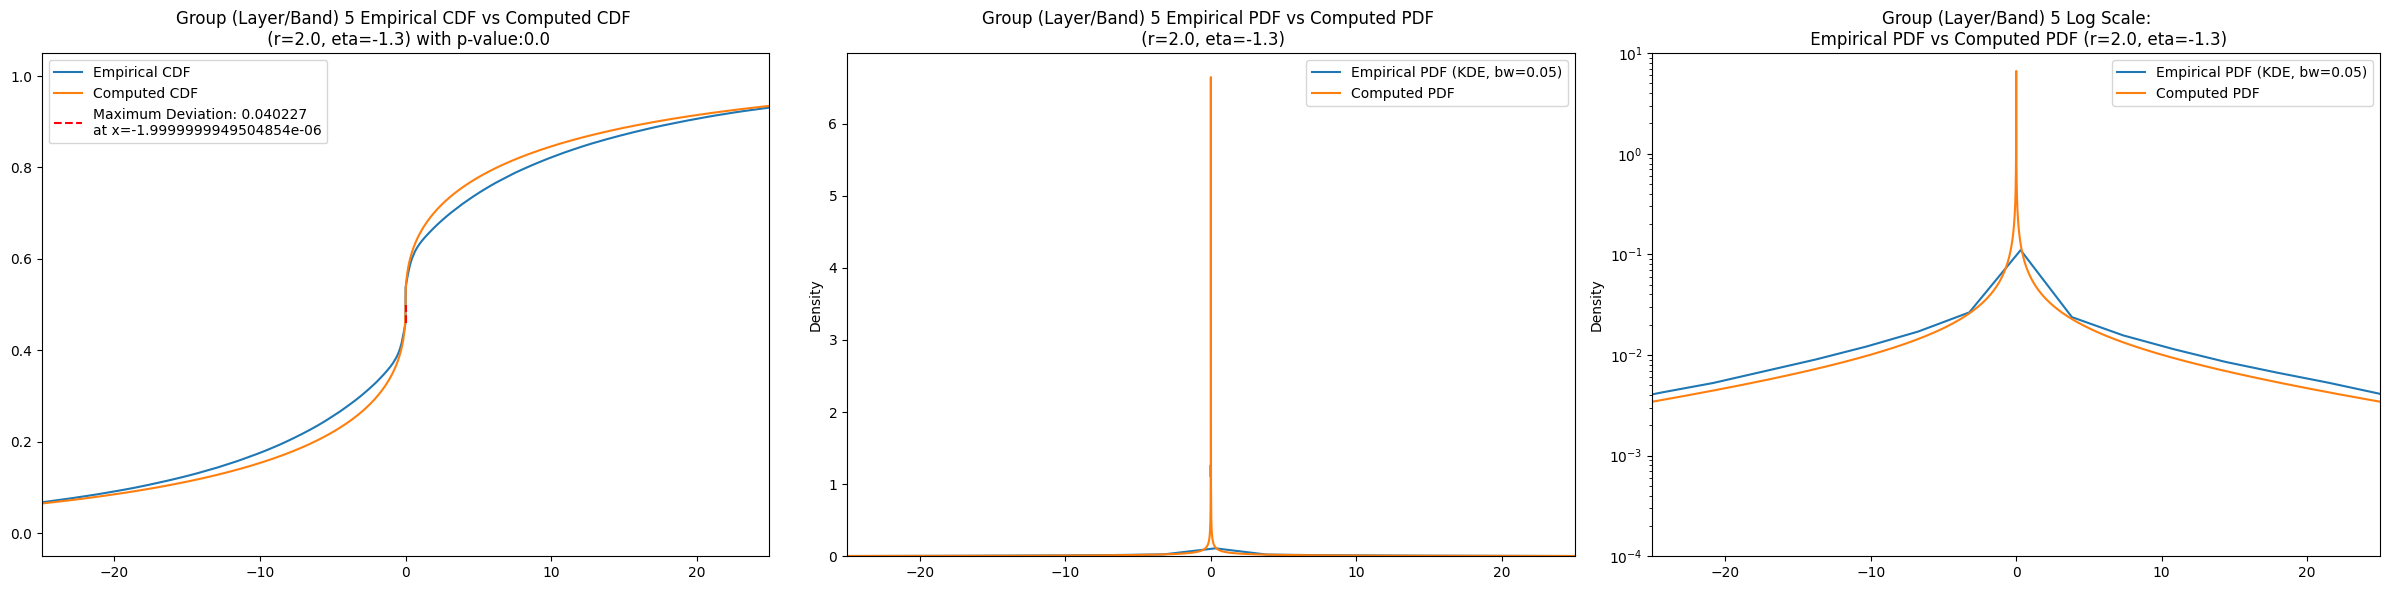

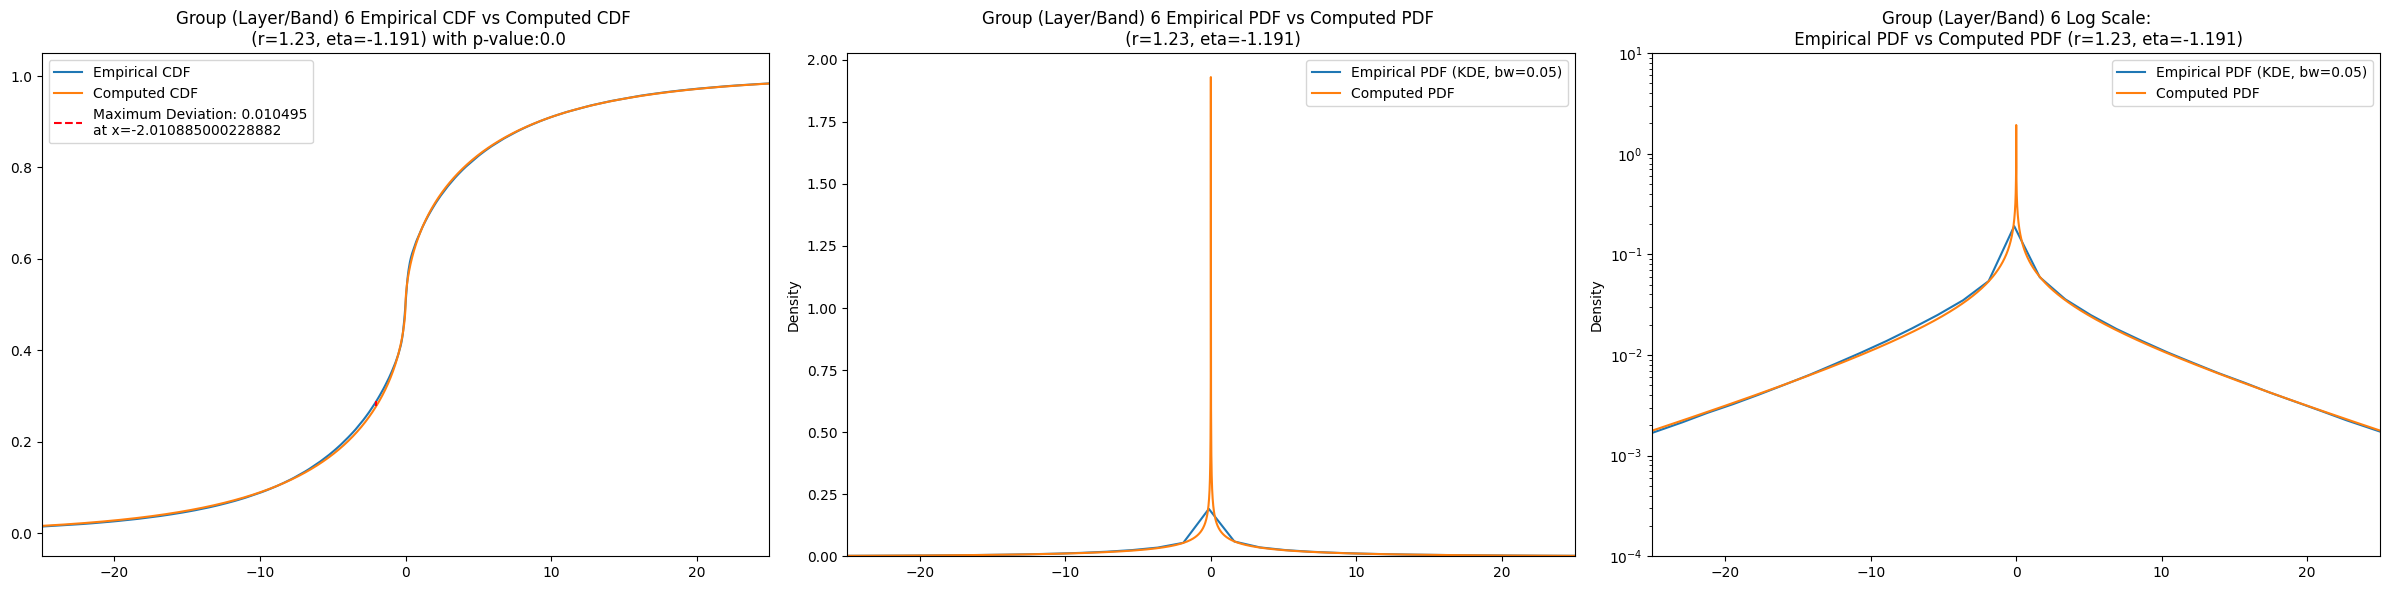

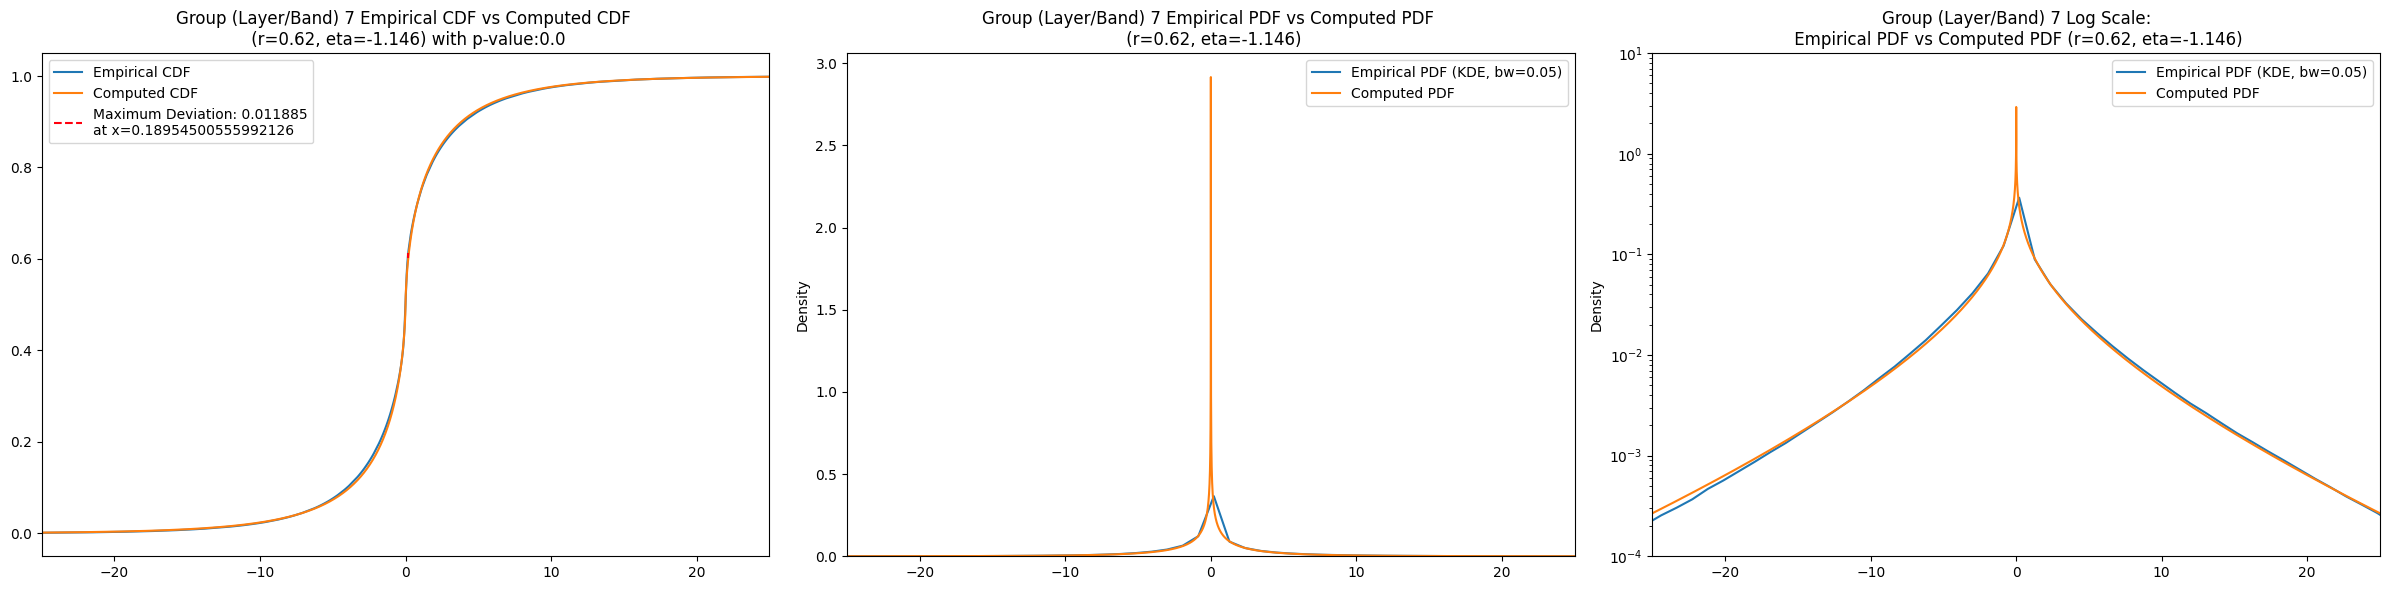

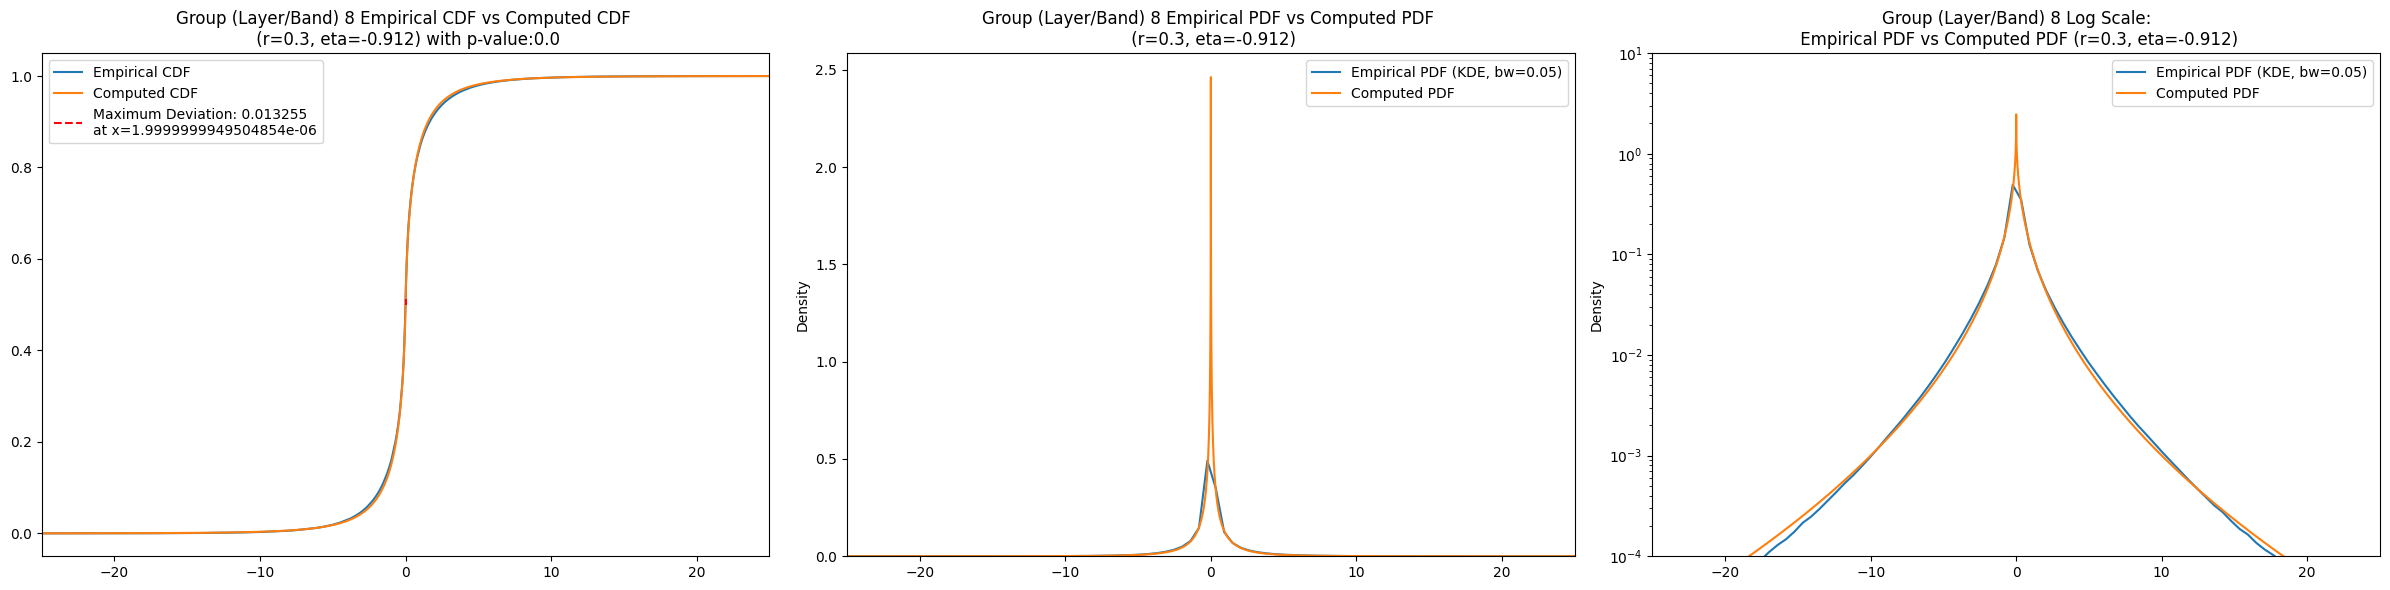

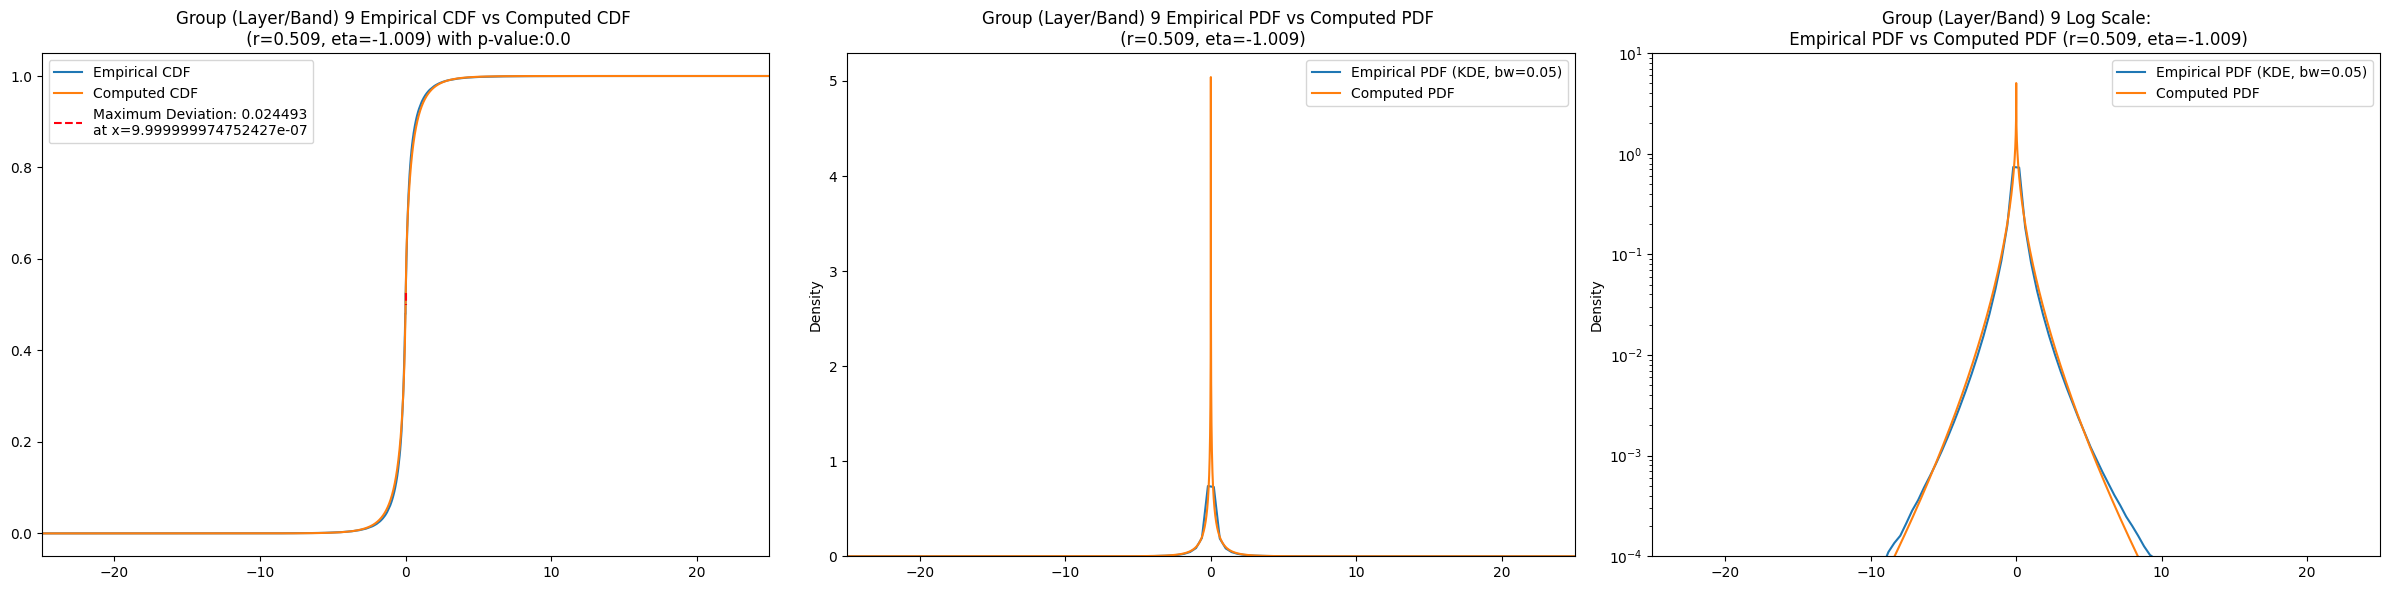

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.006314        27208.0       5.10        -1.00   54579.342195  ...   
3       24.957214       108832.0       0.30        -1.32    1220.308144  ...   
4       16.255730       333298.0       0.69        -1.30    4647.744608  ...   
5       30.039886      1149538.0       2.10        -1.30    2401.725295  ...   
6       28.133839      4251250.0       1.20        -1.19     332.177031  ...   
7       60.114044     17005000.0       0.60        -1.14      27.160989  ...   
8       99.220190     68020000.0       0.30        -0.91       0.117548  ...   
9      442.232270    272080000.0       0.50        -1.00       0.425054  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           94.125800              0.044967          3.033620e-48   
3           20.946400              0.132334          0.000000e+00   
4           15.069000              0.102694          0.000000e+00   
5            8.650160              0.088447          0.000000e+00   
6            4.659030              0.075306          0.000000e+00   
7            1.955420              0.080614          0.000000e+00   
8            0.842763              0.077287          0.000000e+00   
9            0.428234              0.057947          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          78.991400             0.025165         2.115600e-15  65.979900   
3          14.361200             0.131540         0.000000e+00  11.459600   
4          11.775100             0.088325         0.000000e+00   9.475180   
5           6.880400             0.071859         0.000000e+00   5.505590   
6           3.782200             0.055948         0.000000e+00   3.051940   
7           1.620190             0.058797         0.000000e+00   1.289930   
8           0.728513             0.051078         0.000000e+00   0.573774   
9           0.376442             0.030833         0.000000e+00   0.298092   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.031100   2.687470e-23              0.000944  
3           0.131540   0.000000e+00              0.000000  
4           0.091440   0.000000e+00              0.000000  
5           0.075162   0.000000e+00              0.000000  
6           0.060007   0.000000e+00              0.000000  
7           0.062423   0.000000e+00              0.000000  
8           0.052352   0.000000e+00              0.000000  
9           0.030237   0.000000e+00              0.000000  

[8 rows x 33 columns]

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      17165.852000  16108.495000  18292.553000   4.017385    2.713827   
3       4524.570000   4128.018600   4992.178700  11.562076    6.178833   
4       1373.499500   1260.057300   1500.444800   9.261635    6.085780   
5        373.972200    342.441220    410.995540  10.399797    6.170470   
6         90.558690     82.759690     99.775560  11.086198    6.617087   
7         20.864292     18.736567     23.678108  18.333368    9.082987   
8          4.537877      3.986680      5.319919  28.597765   12.662612   
9          0.850108      0.718232      1.177670  97.794940   14.378058   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.006314        27208.0       5.10        -1.00   54579.342195  ...   
3       24.957214       108832.0       0.30        -1.32    1220.308144  ...   
4       16.255730       333298.0       0.69        -1.30    4647.744608  ...   
5       30.039886      1149538.0       2.10        -1.30    2401.725295  ...   
6       28.133839      4251250.0       1.20        -1.19     332.177031  ...   
7       60.114044     17005000.0       0.60        -1.14      27.160989  ...   
8       99.220190     68020000.0       0.30        -0.91       0.117548  ...   
9      442.232270    272080000.0       0.50        -1.00       0.425054  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           94.125800              0.044967          3.033620e-48   
3           20.946400              0.132334          0.000000e+00   
4           15.069000              0.102694          0.000000e+00   
5            8.650160              0.088447          0.000000e+00   
6            4.659030              0.075306          0.000000e+00   
7            1.955420              0.080614          0.000000e+00   
8            0.842763              0.077287          0.000000e+00   
9            0.428234              0.057947          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          78.991400             0.025165         2.115600e-15  65.979900   
3          14.361200             0.131540         0.000000e+00  11.459600   
4          11.775100             0.088325         0.000000e+00   9.475180   
5           6.880400             0.071859         0.000000e+00   5.505590   
6           3.782200             0.055948         0.000000e+00   3.051940   
7           1.620190             0.058797         0.000000e+00   1.289930   
8           0.728513             0.051078         0.000000e+00   0.573774   
9           0.376442             0.030833         0.000000e+00   0.298092   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.031100   2.687470e-23              0.000944  
3           0.131540   0.000000e+00              0.000000  
4           0.091440   0.000000e+00              0.000000  
5           0.075162   0.000000e+00              0.000000  
6           0.060007   0.000000e+00              0.000000  
7           0.062423   0.000000e+00              0.000000  
8           0.052352   0.000000e+00              0.000000  
9           0.030237   0.000000e+00              0.000000  

[8 rows x 33 columns]

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))